In [1]:
# devtools::install_github("maxbiostat/phylodyn", ref = "pc_prior")

In [5]:
library(phylodyn)
library(ape)

In [6]:
Trees.A <- list(
    seed1 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_1_serotype_A_VP1.tree"),
    seed2 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_2_serotype_A_VP1.tree"),
    seed3 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_3_serotype_A_VP1.tree")
)

In [8]:
Trees.O <- list(
    seed1 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_1_serotype_O_VP1.tree"),
    seed2 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_2_serotype_O_VP1.tree"),
    seed3 = read.nexus("~/DUMP/fmdv/temporal_only/mcc_seed_3_serotype_O_VP1.tree")
)

In [10]:
get_reconstructions_cov <- function(tree){
    out <- list(
        naive = phylodyn::BNPR(data = tree, lengthout = 100, pc_prior = FALSE),
        preferential = phylodyn::BNPR_PS(data = tree, lengthout = 100, pc_prior = FALSE),
        preferential_cov = phylodyn::BNPR_PS(data = tree,
                                         fns = list(f1 = function(t) -t),
                                             lengthout = 100, pc_prior = FALSE, log_fns = FALSE),
        preferential_cov_sq = phylodyn::BNPR_PS(data = tree,
                                         fns = list(f1 = function(t) -t, f2 = function(t) -t*t),
                                             lengthout = 100, pc_prior = FALSE, log_fns = FALSE)
                                             
    ) 
    return(out)
}

In [11]:
reconstructions.A <- lapply(Trees.A, get_reconstructions_cov)

In [12]:
reconstructions.O <- lapply(Trees.O, get_reconstructions_cov)

In [13]:
plot_reconstructions <- function(recons, times, verbose = FALSE){
    par(mfrow = c(1, 4))
    ymax <- max( c( max(recons$naive$effpop975),
                   max(recons$preferential$effpop975),
                   max(recons$preferential_cov$effpop975) ))
    if(verbose) cat("max y:", ymax, "\n")
    plot_BNPR(recons$naive, xlab = "Time (years)", axlabs = times,
              ylim = c(0.5, ymax),
              main = "Naive")
    plot_BNPR(recons$preferential, xlab = "Time (years)", axlabs = times,
              ylim = c(0.5, ymax),
              main = "{gamma(t)}")
    plot_BNPR(recons$preferential_cov, xlab = "Time (years)", axlabs = times,
              ylim = c(0.5, ymax),
              main = "{gamma(t), -t}")
    plot_BNPR(recons$preferential_cov_sq, xlab = "Time (years)", axlabs = times,
              ylim = c(0.5, ymax),
              main = "{gamma(t), -t, -t^2}")    
}

In [14]:
tt.A <- list(
    x = c(0, 20, 40, 60, 80),
    labs = as.character(2013 - c(0, 20, 40, 60, 80))
)
tt.O <- list(
    x = c(0, 20, 40, 60, 80),
    labs = as.character(2011 - c(0, 20, 40, 60, 80))
)

In [15]:
options(repr.plot.width = 10, repr.plot.height = 5)

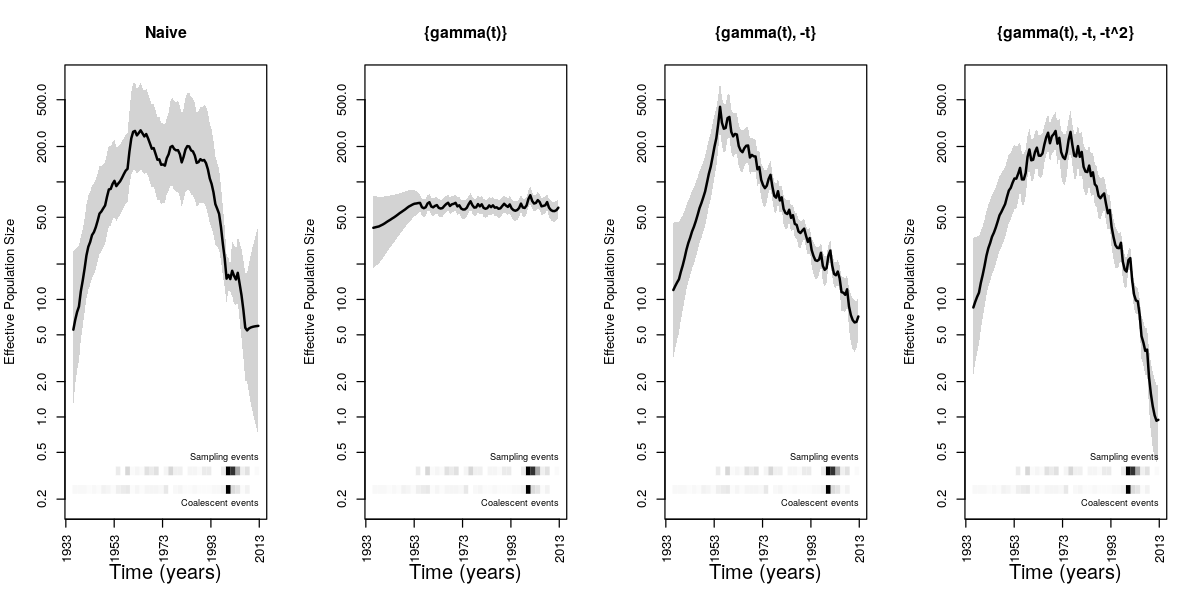

In [16]:
plot_reconstructions(reconstructions.A[[1]], times = tt.A)

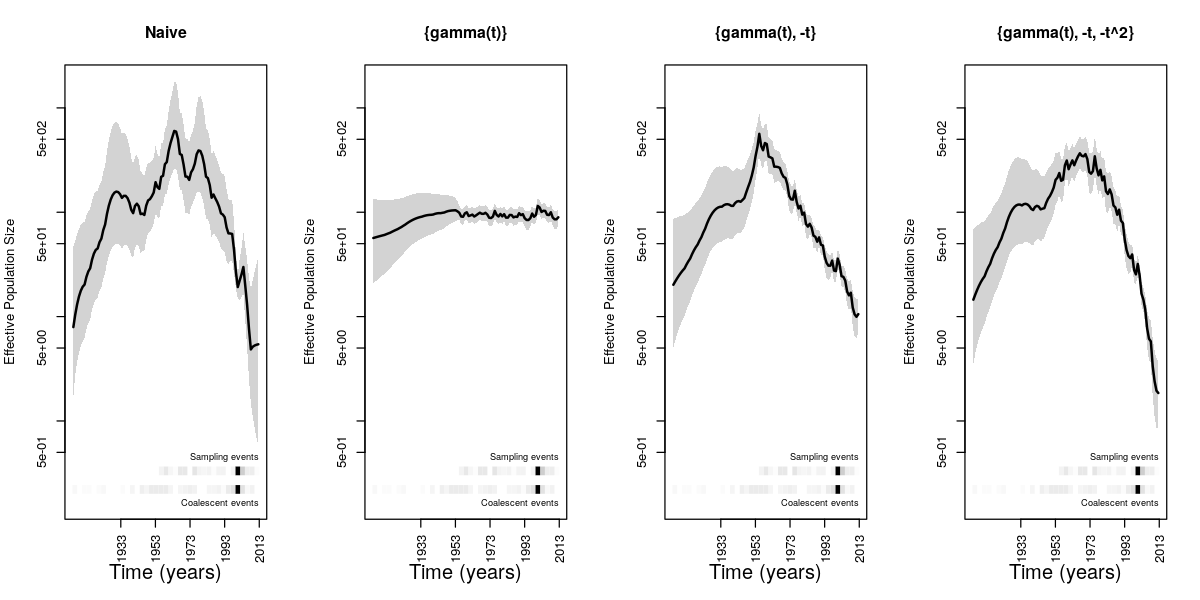

In [17]:
plot_reconstructions(reconstructions.A[[2]], times = tt.A)

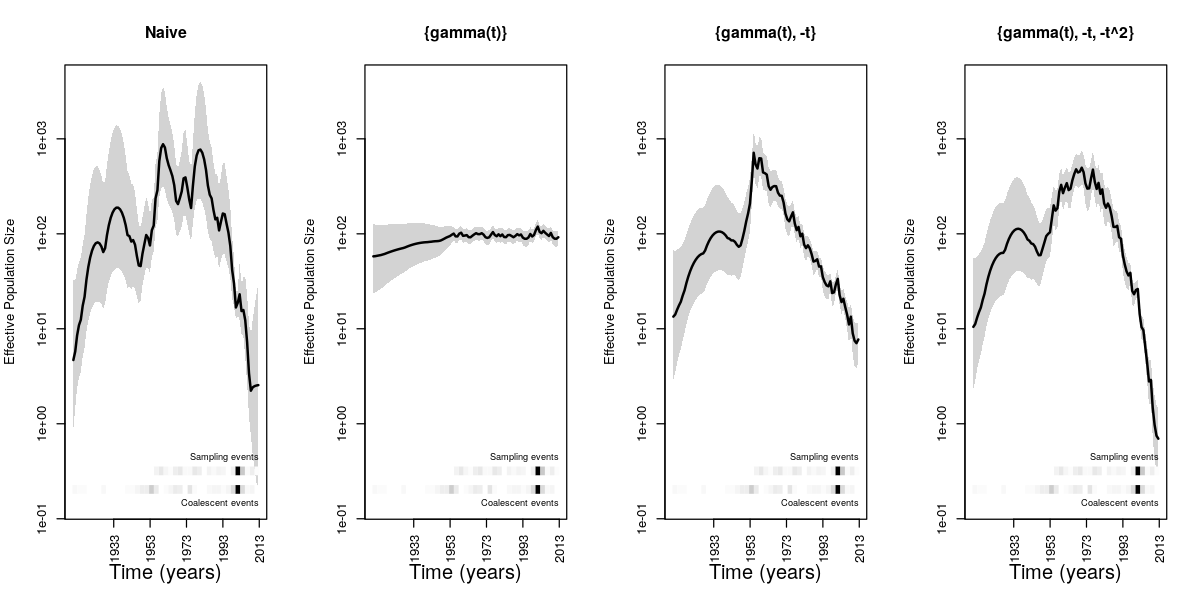

In [18]:
plot_reconstructions(reconstructions.A[[3]], times = tt.A)

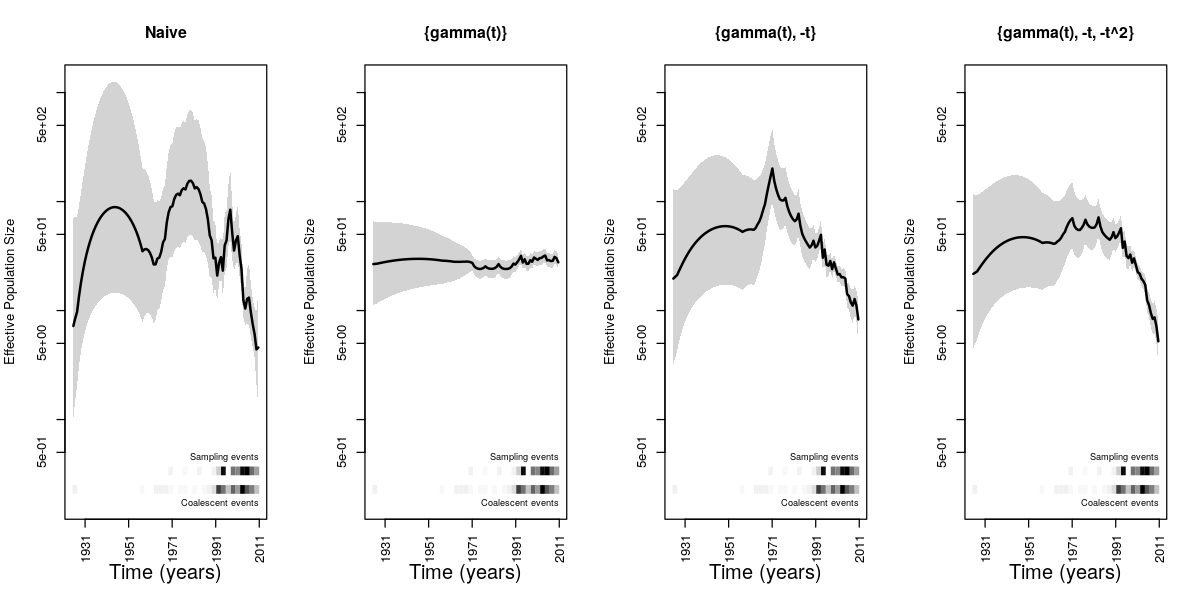

In [19]:
plot_reconstructions(reconstructions.O[[1]], times = tt.O)

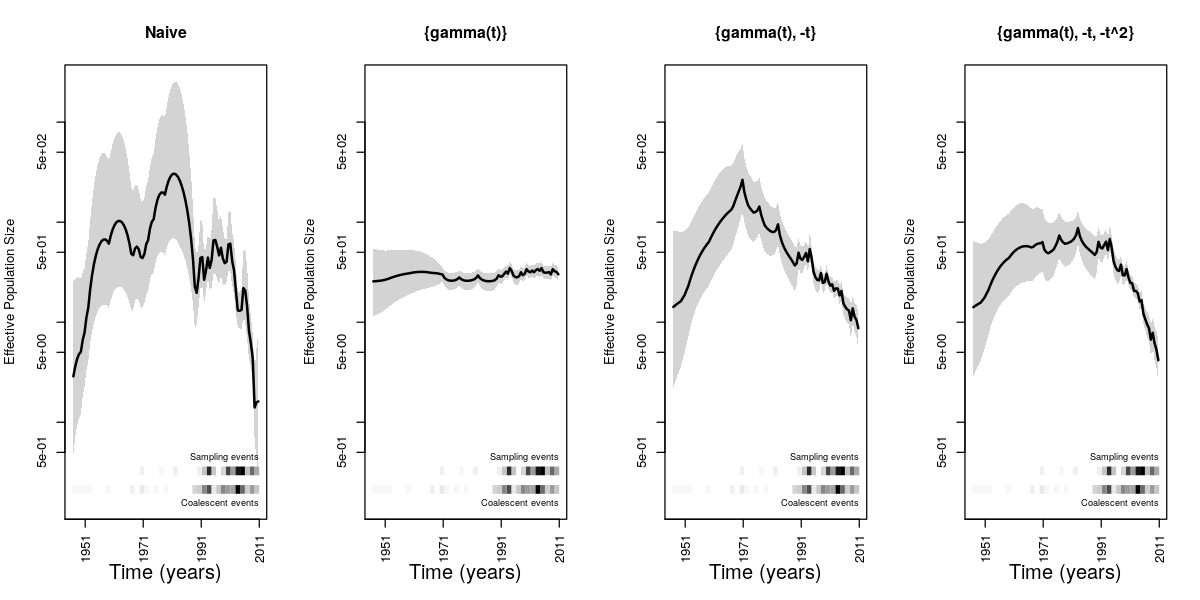

In [20]:
plot_reconstructions(reconstructions.O[[2]], times = tt.O)

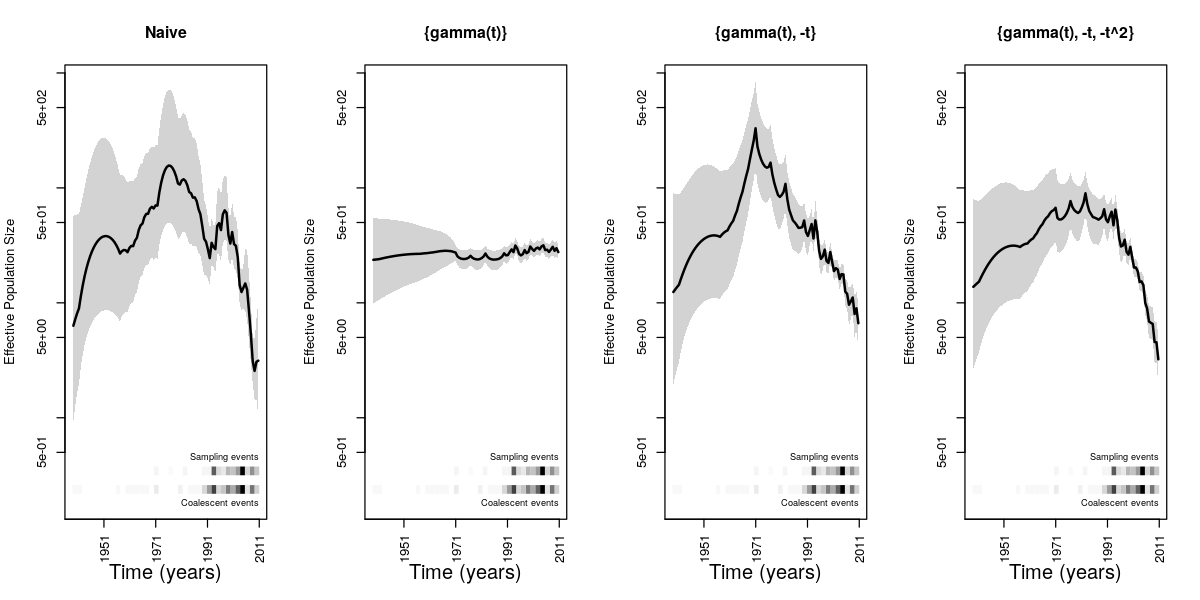

In [21]:
plot_reconstructions(reconstructions.O[[3]], times = tt.O)

In [22]:
plot_reconstructions_overlay <- function(recons, times){
    plot_BNPR(recons$naive, xlab = "Time (years)",
              axlabs = times, col = "blue", credible_region = FALSE)
    plot_BNPR(recons$preferential_cov, xlab = "Time (years)",
              axlabs = times, col = "red", newplot = FALSE, credible_region = FALSE)    
}

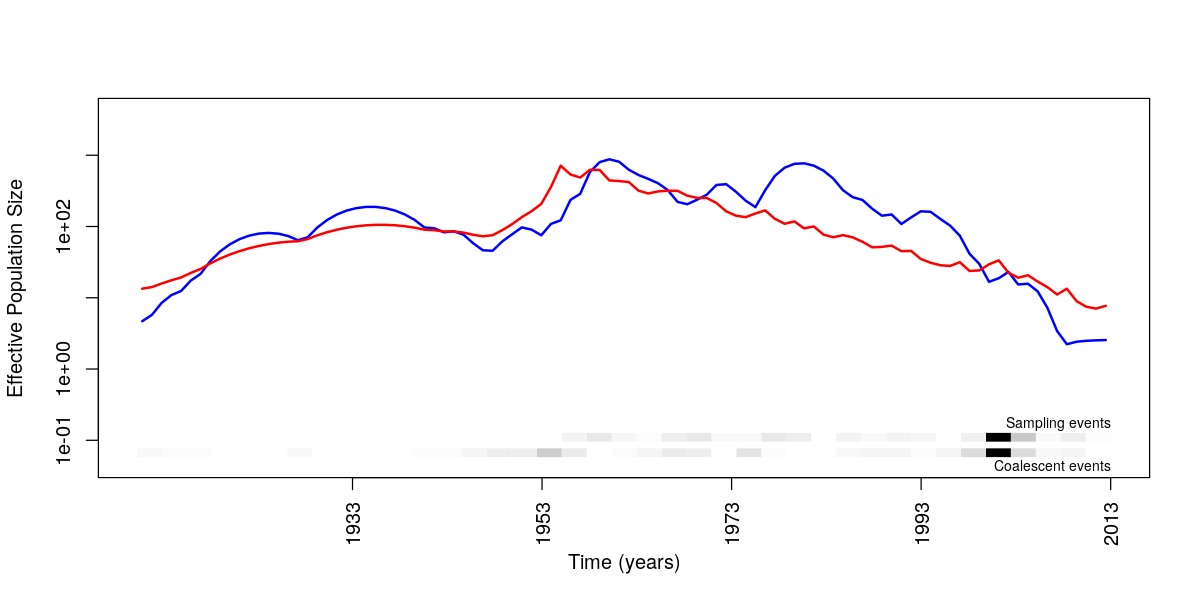

In [23]:
plot_reconstructions_overlay(reconstructions.A[[3]], times = tt.A)


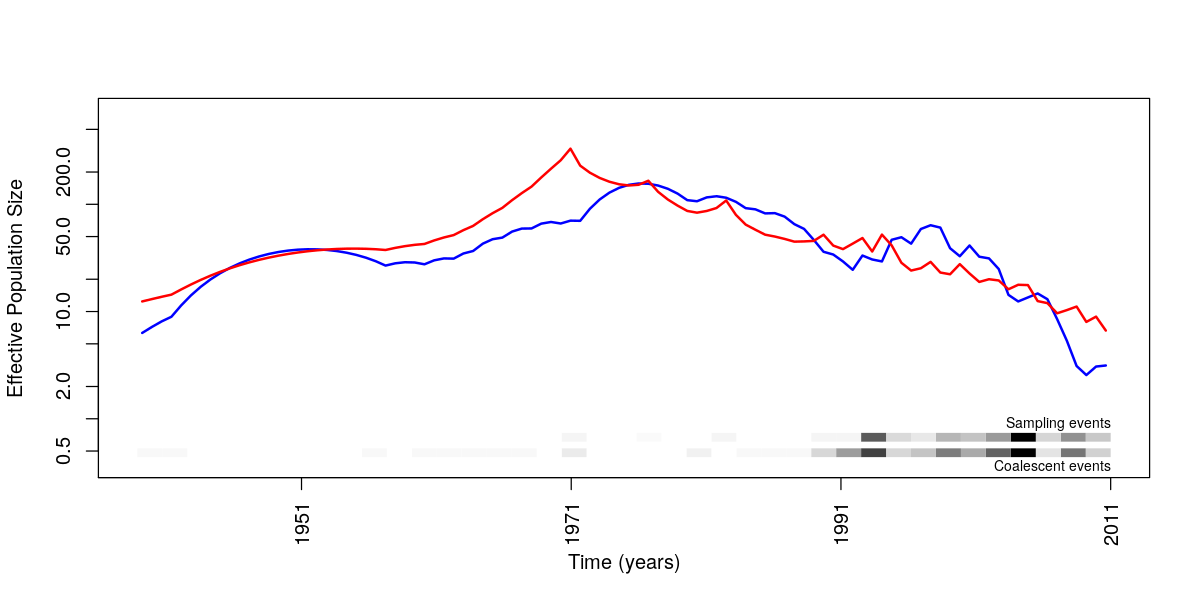

In [24]:
plot_reconstructions_overlay(reconstructions.O[[3]], times = tt.O)

In [25]:
summary( reconstructions.A[[1]]$naive$result )


Call:
c("INLA::inla(formula = formula, family = family, data = data, offset = data$E_log, ",  "    lincomb = lc_many, control.predictor = list(compute = TRUE), ",  "    control.inla = list(lincomb.derived.only = FALSE))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.2800          0.1714          0.0502          0.5016 

The model has no fixed effects

Random effects:
Name	  Model
 time   RW1 model 

Model hyperparameters:
                    mean    sd 0.025quant 0.5quant 0.975quant  mode
Precision for time 7.529 3.725      2.704    6.737      16.94 5.375

Expected number of effective parameters(std dev): 17.88(3.873)
Number of equivalent replicates : 5.592 

Marginal log-Likelihood:  -161.87 
Posterior marginals for linear predictor and fitted values computed


In [26]:
summary( reconstructions.A[[1]]$preferential$result )


Call:
c("INLA::inla(formula = formula, family = family, data = data, offset = data$E_log, ",  "    lincomb = lc_many, control.predictor = list(compute = TRUE), ",  "    control.inla = list(lincomb.derived.only = FALSE))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.1797          0.6493          0.0422          0.8711 

Fixed effects:
          mean    sd 0.025quant 0.5quant 0.975quant     mode    kld
beta0 -86.6838 15.92  -118.9083 -85.3689   -52.5411 -85.0382 0.0022

Random effects:
Name	  Model
 time   RW1 model 
time2   Copy 

Model hyperparameters:
                     mean    sd 0.025quant 0.5quant 0.975quant   mode
Precision for time 181.92 77.72      82.25   164.74     380.99 136.92
Beta for time2      21.71  3.44      15.51    21.48      29.00  20.66

Expected number of effective parameters(std dev): 45.33(3.285)
Number of equivalent replicates : 3.861 

Marginal log-Likelihood:  -433.60 
Posterior marginals for linear predictor and 

In [27]:
summary( reconstructions.A[[1]]$preferential_cov$result )


Call:
c("INLA::inla(formula = formula, family = family, data = data, offset = data$E_log, ",  "    lincomb = lc_many, control.predictor = list(compute = TRUE), ",  "    control.inla = list(lincomb.derived.only = FALSE))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.3131          0.7462          0.0440          1.1034 

Fixed effects:
          mean     sd 0.025quant 0.5quant 0.975quant     mode    kld
beta0 -20.2247 5.2191   -32.1346 -19.3952   -12.2241 -18.3728 0.0013
fn      0.7032 0.1301     0.4939   0.6892     0.9961   0.6701 0.0010

Random effects:
Name	  Model
 time   RW1 model 
time2   Copy 

Model hyperparameters:
                    mean    sd 0.025quant 0.5quant 0.975quant   mode
Precision for time 19.77 7.002     10.554    18.23      37.53 15.578
Beta for time2     10.38 1.842      7.255    10.19      14.44  9.475

Expected number of effective parameters(std dev): 54.13(2.84)
Number of equivalent replicates : 3.233 

Marginal log-

In [28]:
summary( reconstructions.A[[1]]$preferential_cov_sq$result )


Call:
c("INLA::inla(formula = formula, family = family, data = data, offset = data$E_log, ",  "    lincomb = lc_many, control.predictor = list(compute = TRUE), ",  "    control.inla = list(lincomb.derived.only = FALSE))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         0.1994          0.8287          0.0434          1.0715 

Fixed effects:
         mean     sd 0.025quant 0.5quant 0.975quant    mode    kld
beta0  0.8947 2.9373    -5.5643   1.1205     6.0660  1.5377 0.0005
fn1    2.1766 0.4290     1.4740   2.1304     3.1473  2.0589 0.0012
fn2   -0.0256 0.0055    -0.0380  -0.0250    -0.0165 -0.0239 0.0009

Random effects:
Name	  Model
 time   RW1 model 
time2   Copy 

Model hyperparameters:
                     mean    sd 0.025quant 0.5quant 0.975quant   mode
Precision for time 13.425 4.491      7.367    12.49      24.65 10.838
Beta for time2      8.446 1.504      5.902     8.29      11.75  7.711

Expected number of effective parameters(std dev): 55.

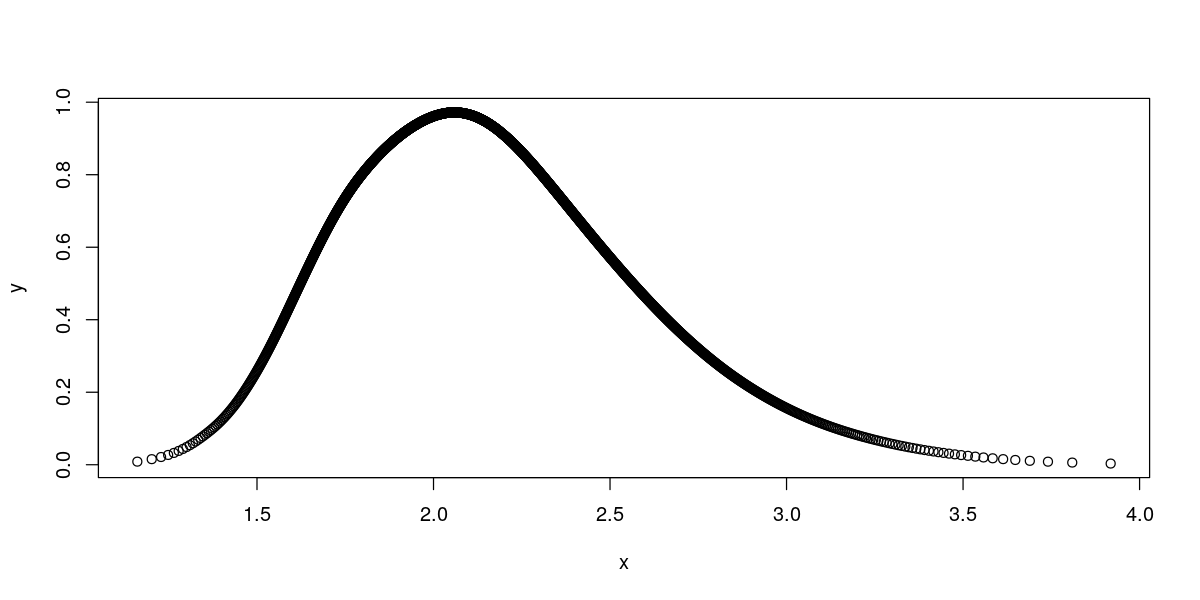

In [29]:
plot(INLA::inla.tmarginal(function(x) x, reconstructions.A[[1]]$preferential_cov_sq$result$marginals.fixed[[2]]) )

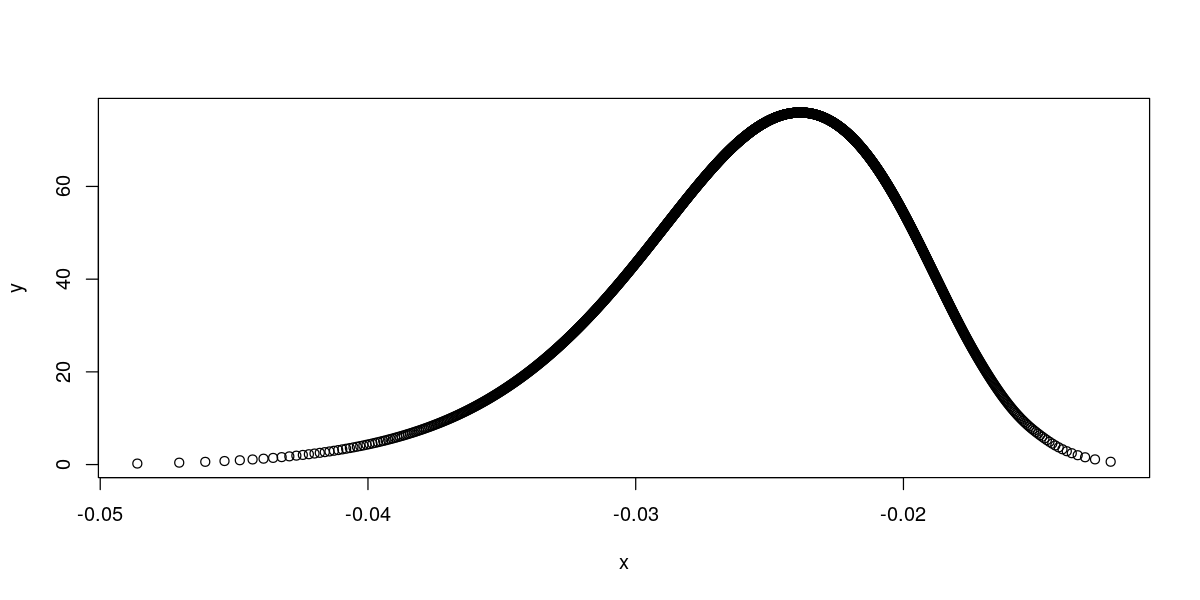

In [30]:
plot(INLA::inla.tmarginal(function(x) x, reconstructions.A[[1]]$preferential_cov_sq$result$marginals.fixed[[3]]) )

In [31]:
get_mal <- function(recon) data.frame( t( summary(recon$result)$mlik) )

In [51]:
mals.A.1 <- do.call(rbind, lapply(reconstructions.A[[1]], get_mal) )
mals.A.1 
mals.A.1.b <- mals.A.1[-1, ]
apply(mals.A.1.b, 2, function(x) x-max(x))

,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
naive,-161.8823,-161.8679
preferential,-433.6764,-433.6041
preferential_cov,-358.5634,-358.5733
preferential_cov_sq,-340.3961,-340.4752


,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
preferential,-93.2803,-93.1289
preferential_cov,-18.1673,-18.0981
preferential_cov_sq,0.0000,0.0000


In [52]:
mals.A.2 <- do.call(rbind, lapply(reconstructions.A[[2]], get_mal) )
mals.A.2 
mals.A.2.b <- mals.A.2[-1, ]
apply(mals.A.2.b, 2, function(x) x-max(x))

,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
naive,-140.7231,-140.7063
preferential,-391.7651,-392.0365
preferential_cov,-310.9804,-311.0890
preferential_cov_sq,-301.9371,-302.1295


,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
preferential,-89.8280,-89.9070
preferential_cov,-9.0433,-8.9595
preferential_cov_sq,0.0000,0.0000


In [53]:
mals.A.3 <- do.call(rbind, lapply(reconstructions.A[[3]], get_mal) )
mals.A.3 
mals.A.3.b <- mals.A.3[-1, ]
apply(mals.A.3.b, 2, function(x) x-max(x))

,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
naive,-136.9175,-136.8986
preferential,-421.5641,-421.7144
preferential_cov,-333.7635,-333.8217
preferential_cov_sq,-307.1697,-307.3262


,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
preferential,-114.3944,-114.3882
preferential_cov,-26.5938,-26.4955
preferential_cov_sq,0.0000,0.0000


In [55]:
mals.O.1 <- do.call(rbind, lapply(reconstructions.O[[1]], get_mal) )
mals.O.1 
mals.O.1.b <- mals.O.1[-1, ]
apply(mals.O.1.b, 2, function(x) x-max(x))

,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
naive,-128.7521,-128.7526
preferential,-295.6117,-297.4362
preferential_cov,-272.3355,-272.2527
preferential_cov_sq,-274.1039,-274.1146


,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
preferential,-23.2762,-25.1835
preferential_cov,0.0000,0.0000
preferential_cov_sq,-1.7684,-1.8619


In [56]:
mals.O.2 <- do.call(rbind, lapply(reconstructions.O[[2]], get_mal) )
mals.O.2 
mals.O.2.b <- mals.O.2[-1, ]
apply(mals.O.2.b, 2, function(x) x-max(x))

,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
naive,-158.3096,-158.2684
preferential,-349.2187,-351.3279
preferential_cov,-324.2381,-323.8686
preferential_cov_sq,-321.0515,-320.8625


,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
preferential,-28.1672,-30.4654
preferential_cov,-3.1866,-3.0061
preferential_cov_sq,0.0000,0.0000


In [57]:
mals.O.3 <- do.call(rbind, lapply(reconstructions.O[[3]], get_mal) )
mals.O.3 
mals.O.3.b <- mals.O.3[-1, ]
apply(mals.O.3.b, 2, function(x) x-max(x))

,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
naive,-146.5817,-146.5639
preferential,-332.3126,-334.3761
preferential_cov,-301.8031,-301.4692
preferential_cov_sq,-298.0204,-297.9653


,log.marginal.likelihood..integration.,log.marginal.likelihood..Gaussian.
preferential,-34.2922,-36.4108
preferential_cov,-3.7827,-3.5039
preferential_cov_sq,0.0000,0.0000


## Preparing pub-ready figure

In [58]:
naive.A <- data.frame(
   time = rev(seq(2013-80, 2013, length.out = 100)),
   median = reconstructions.A$seed1$naive$effpop,
   lwr = reconstructions.A$seed1$naive$effpop025,
   upr = reconstructions.A$seed1$naive$effpop975
)
naive.A$serotype <- "A"
naive.A$method <- "Naive"

In [59]:
sampAware.A <- data.frame(
   time = rev(seq(2013-80, 2013, length.out = 100)),
   median = reconstructions.A$seed1$preferential_cov_sq$effpop,
   lwr = reconstructions.A$seed1$preferential_cov_sq$effpop025,
   upr = reconstructions.A$seed1$preferential_cov_sq$effpop975
)
sampAware.A$serotype <- "A"
sampAware.A$method <- "Sampling+Covariate"

In [60]:
naive.O <- data.frame(
   time = rev(seq(2011-80, 2011, length.out = 100)),
   median = reconstructions.O$seed1$naive$effpop,
   lwr = reconstructions.O$seed1$naive$effpop025,
   upr = reconstructions.O$seed1$naive$effpop975
)
naive.O$serotype <- "O"
naive.O$method <- "Naive"

In [61]:
sampAware.O <- data.frame(
   time = rev(seq(2013-80, 2013, length.out = 100)),
   median = reconstructions.O$seed1$preferential_cov_sq$effpop,
   lwr = reconstructions.O$seed1$preferential_cov_sq$effpop025,
   upr = reconstructions.O$seed1$preferential_cov_sq$effpop975
)
sampAware.O$serotype <- "O"
sampAware.O$method <- "Sampling+Covariate"

In [62]:
FMDV_effpop <- rbind(
    naive.A,
    naive.O,
    sampAware.A,
    sampAware.O
)

In [63]:
library(ggplot2)

In [64]:
options(repr.plot.width = 12, repr.plot.height = 6)

In [65]:
p <- ggplot(data = subset(FMDV_effpop), aes(x = time, y = median,
                                                         colour = serotype, fill = serotype)) +
    geom_line(size = 1.1) +
    geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = .4) +
    facet_grid(.~method) +
    scale_x_continuous("Time (years)", expand = c(0, 0)) +
    scale_y_log10(" (log) Effective population size", expand = c(0, 0)) +
    theme_bw(base_size = 20) +
    theme(panel.spacing.x=unit(1.5, "lines")) +
    scale_colour_manual(values=c("cadetblue", "indianred")) +
    scale_fill_manual(values=c("cadetblue", "indianred")) +
    guides(shape = guide_legend(override.aes = list(size = 3, alpha = 1))) +
NULL

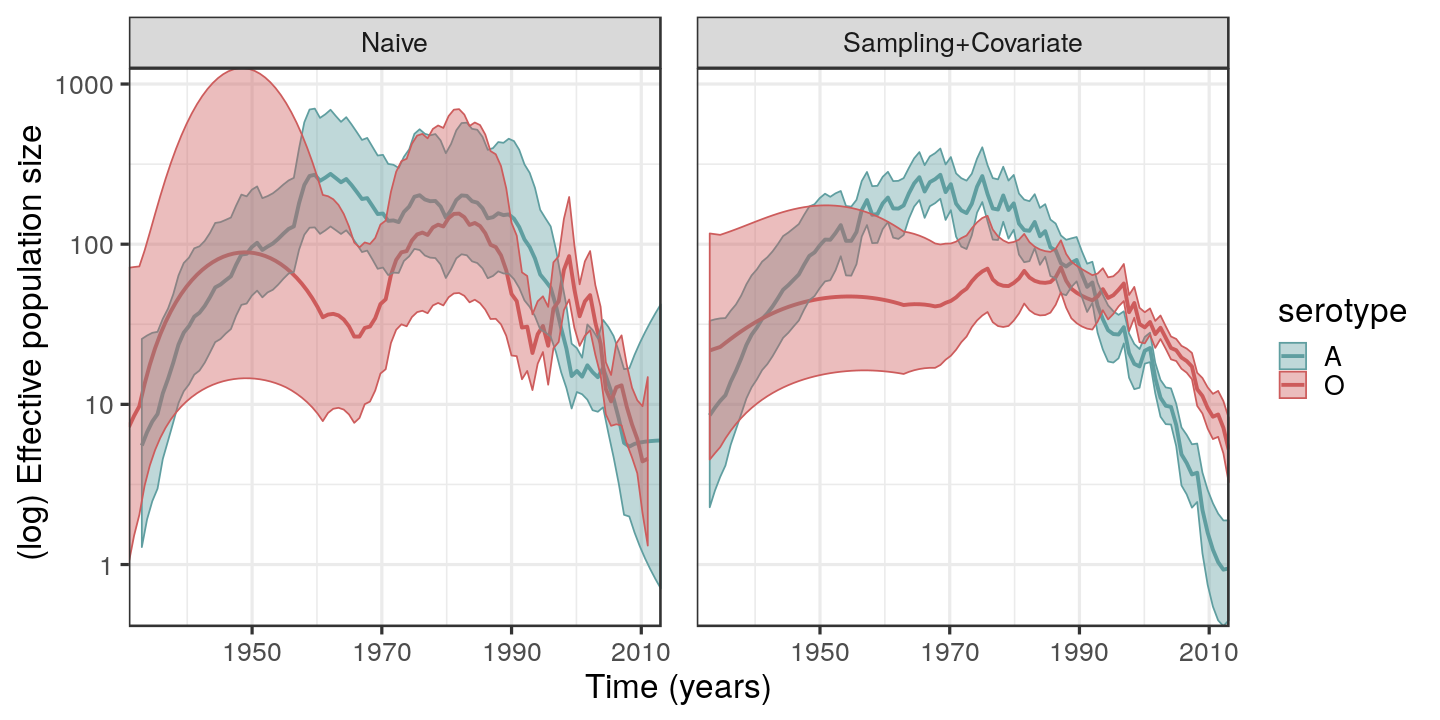

In [66]:
p

In [67]:
ggsave(plot = p, width = 12, height = 6,
       filename = "../../FIGURES/PLOTS/population_size_reconstructions_full.pdf")

In [68]:
p1 <- ggplot(data = subset(FMDV_effpop), aes(x = time, y = median,
                                                         colour = serotype, fill = serotype)) +
    geom_line(size = 1.1) +
    geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = .4) +
    facet_grid(.~method) +
#     geom_line(data = all.cases, size = 1.2,
#              mapping = aes(x = time, y = cases)) + 
    scale_x_continuous("Time (years)", expand = c(0, 0), lim = c(1990, 2013)) +
    scale_y_log10(" (log) Effective population size", expand = c(0, 0)) +
    theme_bw(base_size = 20) +
    theme(panel.spacing.x=unit(1.5, "lines")) +
    scale_colour_manual(values=c("cadetblue", "indianred")) +
    scale_fill_manual(values=c("cadetblue", "indianred")) +
    guides(shape = guide_legend(override.aes = list(size = 3, alpha = 1))) +
NULL

Warning message:
“Removed 142 rows containing missing values (geom_path).”

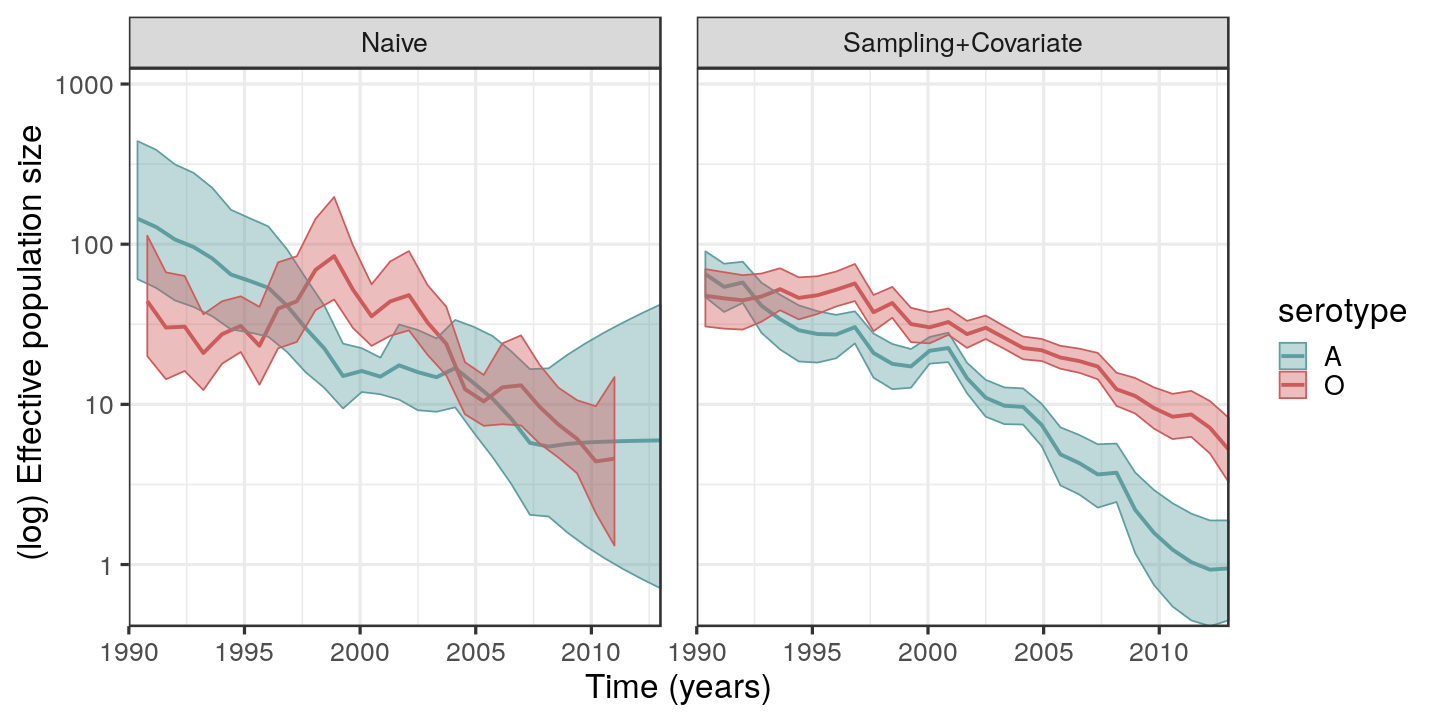

In [69]:
p1

In [47]:
ggsave(plot = p1, width = 12, height = 6,
       filename = "../../FIGURES/PLOTS/population_size_reconstructions_1990s.pdf")

Warning message:
“Removed 142 rows containing missing values (geom_path).”